In [24]:
import os
import numpy as np
import time
import sys
import csv
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as tfunc
from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import *
import torch.nn.functional as func

from sklearn.metrics.ranking import roc_auc_score
import sklearn.metrics as metrics
import random

import h5py
import scipy
from scipy import ndimage

import pandas as pd
import math
from tensorflow.python.framework import ops
from numpy import zeros, newaxis
import tensorflow as tf


In [25]:
pathFileTrain = "/Users/Lisa/cs230_project/CheXpert-v1.0-small/train.csv"
pathFileValid = "/Users/Lisa/cs230_project/CheXpert-v1.0-small/valid.csv"
# Neural network parameters:
nnIsTrained = False                 #pre-trained using ImageNet
nnClassCount = 14                   #dimension of the output

# Training settings: batch size, maximum number of epochs
trBatchSize = 64
trMaxEpoch = 3

# Parameters related to image transforms: size of the down-scaled image, cropped image
imgtransResize = (320, 320)
imgtransCrop = 224

# Class names
class_names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 
               'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax', 
               'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices']

In [26]:
# The following class implementation was taken  from this specific repo:
# https://github.com/gaetandi/cheXpert/blob/master/cheXpert_final.ipynb

class CheXpertDataSet(Dataset):
    def __init__(self, image_list_file, policy="ones"):
        """
        image_list_file: path to the file containing images with corresponding labels.
        transform: optional transform to be applied on a sample.
        Upolicy: name the policy with regard to the uncertain labels
        """
        image_names = []
        labels = []

        with open(image_list_file, "r") as f:
            csvReader = csv.reader(f)
            next(csvReader, None)
            k=0
            for line in csvReader:
                k+=1
                image_name= line[0]
                label = line[5:]
                
                for i in range(14):
                    if label[i]:
                        a = float(label[i])
                        if a == 1:
                            label[i] = 1
                        elif a == -1:
                            if policy == "ones":
                                label[i] = 1
                            elif policy == "zeroes":
                                label[i] = 0
                            else:
                                label[i] = 0
                        else:
                            label[i] = 0
                    else:
                        label[i] = 0
                        
                image_names.append('../cs230_project/' + image_name)
                labels.append(label)

        self.image_names = image_names
        self.labels = labels
#        self.transform = transform

    def __getitem__(self, index):
        """Take the index of item and returns the image and its labels"""
        
        image_name = self.image_names[index]
        image = Image.open(image_name).convert('L')
        image.load()
        image = image.resize((224, 224), Image.ANTIALIAS)  
        data = np.asarray(image, dtype="float64")
        this_x = np.array(data)
        
        label = self.labels[index]
        #torch.FloatTensor(label)
        this_y = np.array(np.asarray(label, dtype="float64"))
        
        
        #if self.transform is not None:
            #image = self.transform(image)         
            
        return this_x, this_y

    def __len__(self):
        return len(self.image_names)

In [27]:
#TRANSFORM DATA - this was not used for the baseline mode. 

#normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#transformList = []
#transformList.append(transforms.Resize(imgtransCrop))
#transformList.append(transforms.RandomResizedCrop(imgtransCrop))
#transformList.append(transforms.RandomHorizontalFlip())
#transformList.append(transforms.ToTensor())
#transformList.append(normalize)      
#transformSequence=transforms.Compose(transformList)

In [28]:
# Create empty arrays to append data later
x_train = []
y_train = []
x_test = []
y_test = []

#LOAD DATASET
dataset = CheXpertDataSet(pathFileTrain, policy="ones")
datasetDev, datasetTrain = random_split(dataset, [500, len(dataset) - 500])
datasetTest = CheXpertDataSet(pathFileValid)            

#dataLoaderTrain = DataLoader(dataset=datasetTrain, batch_size=trBatchSize, shuffle=True,  num_workers=24, pin_memory=True)
#dataLoaderVal = DataLoader(dataset=datasetValid, batch_size=trBatchSize, shuffle=False, num_workers=24, pin_memory=True)
#dataLoaderTest = DataLoader(dataset=datasetTest, num_workers=24, pin_memory=True)


# Create dataset
for i in range (1000):
    this_x_train, this_y_train = datasetTrain.__getitem__(i)
    x_train.append(this_x_train)
    y_train.append(this_y_train)

for i in range (len(datasetTest.labels)):    
    this_x_test, this_y_test = datasetTest.__getitem__(i)
    x_test.append(this_x_test)
    y_test.append(this_y_test)
    
    
X_train = np.array(x_train)
Y_train = np.array(y_train)
X_test = np.array(x_test)
Y_test = np.array(y_test)
# Confirm size of data
print(X_train.shape)
print(Y_train[1])


(1000, 224, 224)
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


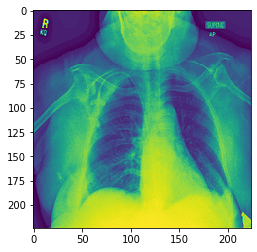

In [29]:
# Confirm image was correctly converted into a numpy array by displaying image back
index = 3
plt.imshow(X_train[index])

In [30]:
# Review size of the data
X_train = np.reshape(X_train , (X_train.shape[0],X_train.shape[1],X_train.shape[2],1))
X_test = np.reshape(X_test , (X_test.shape[0],X_test.shape[1],X_test.shape[2],1))
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 1000
number of test examples = 234
X_train shape: (1000, 224, 224, 1)
Y_train shape: (1000, 14)
X_test shape: (234, 224, 224, 1)
Y_test shape: (234, 14)


In [31]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    
    X = tf.placeholder(tf.float32, shape = (None, n_H0, n_W0, n_C0))
    Y = tf.placeholder(tf.float32, shape = (None, n_y))
    
    
    return X, Y

In [32]:
X, Y = create_placeholders(224, 224, 1, 14)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder_2:0", shape=(?, 224, 224, 1), dtype=float32)
Y = Tensor("Placeholder_3:0", shape=(?, 14), dtype=float32)


In [33]:
def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 1, 8]
                        W2 : [2, 2, 8, 16]
    Note that we will hard code the shape values in the function. 
    Normally, functions should take values as inputs rather than hard coding.
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              
        
    
    W1 = tf.get_variable("W1",[4,4,1,8], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    #W3 = tf.get_variable("W3",[2,2,8,16], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [34]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Note that for simplicity, we'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED with non-linear activation function.
    # 14 neurons in output layer.  
    Z3 = tf.contrib.layers.fully_connected(F, 14, activation_fn = tf.nn.sigmoid)
    # Why does coursera have us use a none activation?? 

    return Z3

In [35]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(224, 224, 1, 14)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,224,224,1), Y: np.random.randn(2,14)})
    print("Z3 = \n" + str(a))

Z3 = 
[[-1.8719702  -0.71147555 -3.7908528  -0.15057558 -0.487876    2.3317246
   0.42052585 -0.48257565 -1.1264129   0.6288618  -0.7844493   1.2535431
  -0.98842084 -1.4293773 ]
 [-1.6571889  -0.6822904  -3.5831318  -0.03690606 -0.2522719   2.407249
   0.6657326  -0.54224193 -1.029184    0.6557939  -0.75956523  1.4211723
  -0.7885181  -1.5113347 ]]


In [36]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (number of examples, 14)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    
    
    return cost

In [37]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(224, 224, 1, 14)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,224,224,1), Y: np.random.randn(4,14)})
    print("cost = " + str(a))

cost = -3.7227173


In [38]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, nx, ny, channel)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (number of examples, labels 14)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    np.random.seed(seed)            
    m = X.shape[0]                  # number of training examples
    mini_batches = []
        
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:] # create permutiation on examples 
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        
        mini_batch_X = shuffled_X[(k)*mini_batch_size : (k+1)*mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[(k)*mini_batch_size : (k+1)*mini_batch_size,:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:

        mini_batch_X = shuffled_X[(num_complete_minibatches)*mini_batch_size:m,:,:,:]
        mini_batch_Y = shuffled_Y[(num_complete_minibatches)*mini_batch_size:m,:]

        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [39]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.000009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)


    # Initialize parameters
    parameters = initialize_parameters()

    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                """
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost.
                # The feedict should contain a minibatch for (X,Y).
                """
                
                _ , temp_cost = sess.run([optimizer, cost],
                                         feed_dict = {X: minibatch_X, Y: minibatch_Y})
                
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 510.962887
Cost after epoch 5: 391.805719
Cost after epoch 10: 289.452586
Cost after epoch 15: 239.949779
Cost after epoch 20: 215.828938
Cost after epoch 25: 199.163291
Cost after epoch 30: 187.411917
Cost after epoch 35: 177.994340
Cost after epoch 40: 172.491912
Cost after epoch 45: 167.063240
Cost after epoch 50: 164.618664
Cost after epoch 55: 161.318939
Cost after epoch 60: 160.161309
Cost after epoch 65: 158.673960
Cost after epoch 70: 156.673564
Cost after epoch 75: 156.722342
Cost after epoch 80: 156.705802
Cost after epoch 85: 155.521740
Cost after epoch 90: 154.829018
Cost after epoch 95: 152.104359


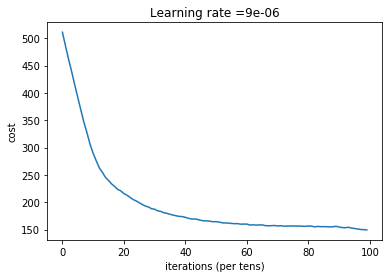

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.115
Test Accuracy: 0.08974359


In [40]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)